In [1]:
import os
import numpy as np
import pandas as pd
import pulse2percept as p2p
import p2pspatial
import pickle
import sklearn.metrics as sklm
import scipy.stats as sps

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-03 14:01:33,174 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [3]:
X, y = p2pspatial.load_data(rootfolder, subject=None, electrodes=None,
                            single_stim=True, verbose=False)

In [4]:
for key in ['area', 'orientation', 'major_axis_length', 'minor_axis_length']:
    print('%s: pearson=%.3f, spearman=%.3f' % (key, X['amp'].corr(y[key], method='pearson'),
                                               X['amp'].corr(y[key], method='spearman')))

area: pearson=0.344, spearman=0.030
orientation: pearson=0.091, spearman=0.103
major_axis_length: pearson=-0.021, spearman=0.004
minor_axis_length: pearson=0.215, spearman=0.098


In [5]:
idx_elongated = y['major_axis_length'] / y['minor_axis_length'] > 2
idx_compact = np.logical_not(idx_elongated)
idx_all = np.ones_like(y['area'], dtype=np.bool)

In [6]:
print('elongated')
for key in ['area', 'orientation', 'major_axis_length', 'minor_axis_length']:
    print('%s: pearson=%.3f, spearman=%.3f' % (key, X.loc[idx_elongated, 'amp'].T.corr(y.loc[idx_elongated, key].T,
                                                                                       method='pearson'),
                                               X.loc[idx_elongated, 'amp'].T.corr(y.loc[idx_elongated, key].T, 
                                                                                  method='spearman')))

elongated
area: pearson=0.039, spearman=-0.194
orientation: pearson=0.127, spearman=0.102
major_axis_length: pearson=-0.033, spearman=-0.042
minor_axis_length: pearson=0.048, spearman=-0.101


In [7]:
print('compact')
for key in ['area', 'orientation', 'major_axis_length', 'minor_axis_length']:
    print('%s: pearson=%.3f, spearman=%.3f' % (key, X.loc[idx_compact, 'amp'].T.corr(y.loc[idx_compact, key].T, 
                                                                                     method='pearson'),
                                               X.loc[idx_compact, 'amp'].T.corr(y.loc[idx_compact, key].T, 
                                                                                method='spearman')))

compact
area: pearson=0.471, spearman=0.415
orientation: pearson=0.003, spearman=0.054
major_axis_length: pearson=0.273, spearman=0.343
minor_axis_length: pearson=0.345, spearman=0.422


In [8]:
subjects = ['12-005', '51-009', '52-001', 'all']

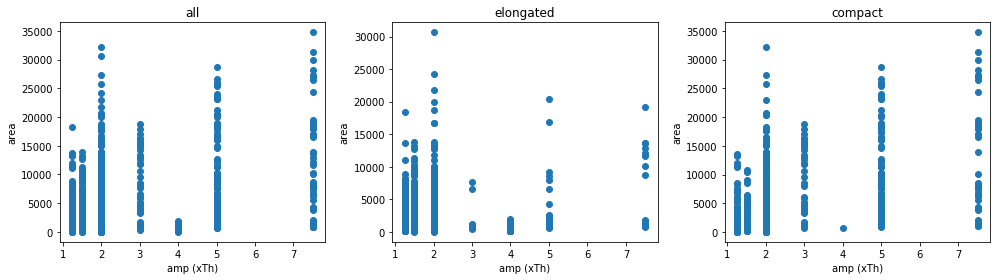

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
for ax, idx in zip(axes.ravel(), ['all', 'elongated', 'compact']):
    if idx == 'all':
        rows = np.ones_like(y['area'], dtype=np.bool)
    elif idx == 'elongated':
        rows = y['major_axis_length'] / y['minor_axis_length'] > 2
    else:
        rows = y['major_axis_length'] / y['minor_axis_length'] <= 2
    ax.scatter(X.loc[rows, 'amp'], y.loc[rows, 'area'])
    ax.set_xlabel('amp (xTh)')
    ax.set_ylabel('area')
    ax.set_title(idx)
plt.tight_layout()
plt.savefig('amp-vs-area.png')

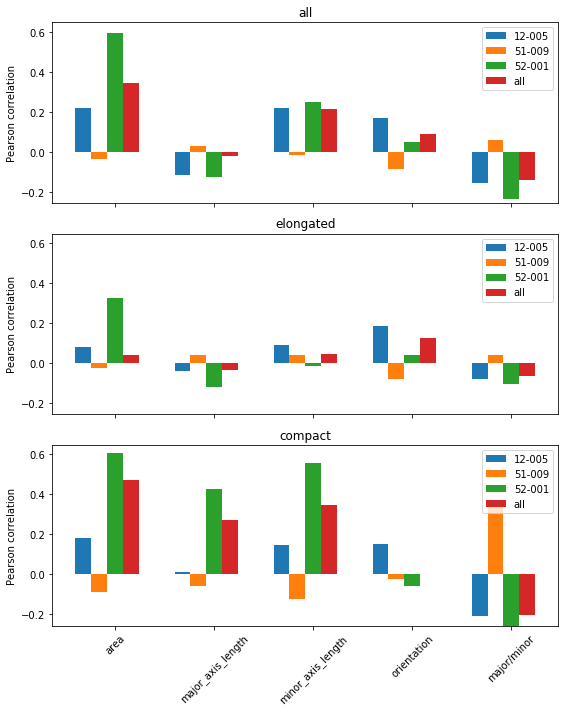

In [11]:
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8, 10))
for ax, idx in zip(axes.ravel(), ['all', 'elongated', 'compact']):
    rects = []
    for s, subject in enumerate(subjects):
        subject = None if subject == 'all' else subject
        X, y = p2pspatial.load_data(rootfolder, subject=subject, electrodes=None,
                                    single_stim=True, verbose=False)
        y['major/minor'] = y['major_axis_length'] / y['minor_axis_length']
        N = len(y.columns)
        ind = np.arange(N)
        width = 0.8 / N
        if idx == 'all':
            rows = np.ones_like(y['area'], dtype=np.bool)
        elif idx == 'elongated':
            rows = y['major/minor'] > 2
        else:
            rows = y['major/minor'] <= 2
        corr = [X.loc[rows, 'amp'].T.corr(y.loc[rows, key].T, method='pearson') for key in y.columns]
        rects.append(ax.bar(ind + s * width, corr, width))
    ax.legend([r[0] for r in rects], subjects)
    ax.set_xticks(ind + (N - 1) / 2 * width)
    ax.set_xticklabels(y.columns, rotation=45, ha='center')
    ax.set_ylabel('Pearson correlation')
    ax.set_title(idx)
plt.tight_layout()
plt.savefig('pearson-corr.png')

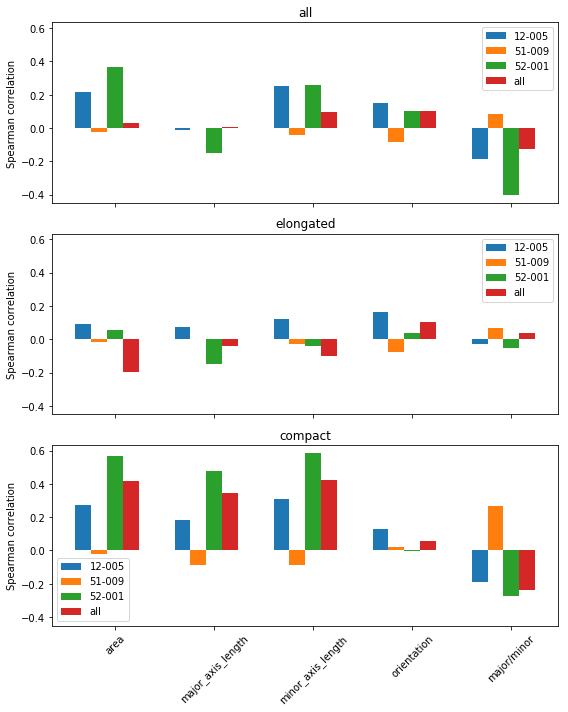

In [12]:
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8, 10))
for ax, idx in zip(axes.ravel(), ['all', 'elongated', 'compact']):
    rects = []
    for s, subject in enumerate(subjects):
        subject = None if subject == 'all' else subject
        X, y = p2pspatial.load_data(rootfolder, subject=subject, electrodes=None,
                                    single_stim=True, verbose=False)
        y['major/minor'] = y['major_axis_length'] / y['minor_axis_length']
        N = len(y.columns)
        ind = np.arange(N)
        width = 0.8 / N
        if idx == 'all':
            rows = np.ones_like(y['area'], dtype=np.bool)
        elif idx == 'elongated':
            rows = y['major/minor'] > 2
        else:
            rows = y['major/minor'] <= 2
        corr = [X.loc[rows, 'amp'].T.corr(y.loc[rows, key].T, method='spearman') for key in y.columns]
        rects.append(ax.bar(ind + s * width, corr, width))
    ax.legend([r[0] for r in rects], subjects)
    ax.set_xticks(ind + (N - 1) / 2 * width)
    ax.set_xticklabels(y.columns, rotation=45, ha='center')
    ax.set_ylabel('Spearman correlation')
    ax.set_title(idx)
plt.tight_layout()
plt.savefig('spearman-corr.png')

Spearman observations:
- on average, phosphenes don't change much with amp! however, we can break it down a bit...
- large inter-subject differences: 51-009 might be an outlier, doesn't change much. 52-001 has the most drastic size changes
- compact phosphenes increase in size
- elongated phosphenes don't change much
- orientation is relatively stable

Open questions:
- why is elongated-all so negative but individuals are all positive? => probably because 
- is 51-009 the outlier? or is it 52-001? 12-005 seems the most balanced, with moderate size increases, and some elongated shape

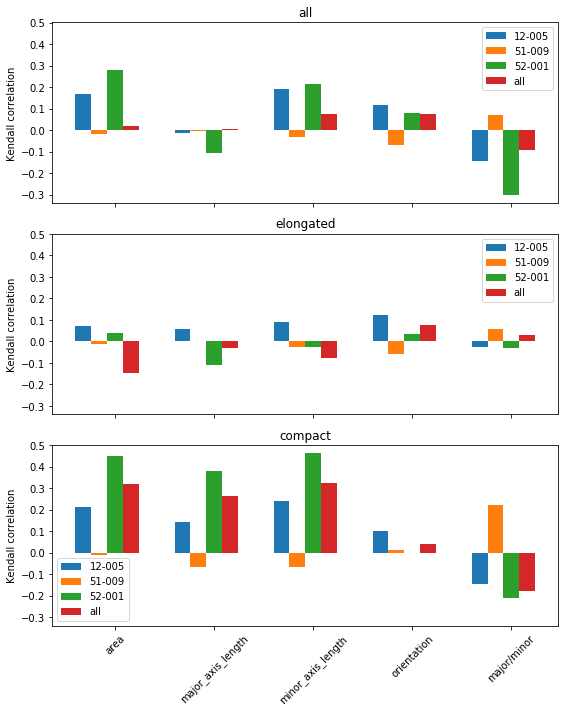

In [13]:
fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(8, 10))
for ax, idx in zip(axes.ravel(), ['all', 'elongated', 'compact']):
    rects = []
    for s, subject in enumerate(subjects):
        subject = None if subject == 'all' else subject
        X, y = p2pspatial.load_data(rootfolder, subject=subject, electrodes=None,
                                    single_stim=True, verbose=False)
        y['major/minor'] = y['major_axis_length'] / y['minor_axis_length']
        N = len(y.columns)
        ind = np.arange(N)
        width = 0.8 / N
        if idx == 'all':
            rows = np.ones_like(y['area'], dtype=np.bool)
        elif idx == 'elongated':
            rows = y['major/minor'] > 2
        else:
            rows = y['major/minor'] <= 2
        corr = [X.loc[rows, 'amp'].T.corr(y.loc[rows, key].T, method='kendall') for key in y.columns]
        rects.append(ax.bar(ind + s * width, corr, width))
    ax.legend([r[0] for r in rects], subjects)
    ax.set_xticks(ind + (N - 1) / 2 * width)
    ax.set_xticklabels(y.columns, rotation=45, ha='center')
    ax.set_ylabel('Kendall correlation')
    ax.set_title(idx)
plt.tight_layout()
plt.savefig('kendall-corr.png')